In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import shap
import warnings
import sys
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import auto_co2 as co2

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.insert(0, '../src/')

file_path = "../data/processed/co2_classification_20240112-161106.pkl"

# Convert the loaded data to a DataFrame
df = pd.read_pickle(file_path)

2024-01-14 01:16:10.331472: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 01:16:10.347986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **0. Introduction**


In [2]:
co2.styles.display_info(df)
target = df['Co2Grade']
data = df.drop(columns='Co2Grade')

co2.styles.displayer(data)
co2.styles.displayer(pd.DataFrame(target))

co2.viz.plot_distribution_pie(target, interactive=True, save=True, format='png')

,Column,Non-Null Count,Dtype
0,MassRunningOrder,4749 non-null,float64
1,BaseWheel,4749 non-null,float64
2,EnginePower,4749 non-null,float64
3,InnovativeTechnology,4749 non-null,int64
4,ElecRange_NO_RANGE,4749 non-null,int64
5,ElecRange_0to50,4749 non-null,int64
6,ElecRange_50to100,4749 non-null,int64
7,ElecRange_100to150,4749 non-null,int64
8,ElecRange_150+,4749 non-null,int64
9,Pool_BMW,4749 non-null,int64


,Info
0,"Index: 4749 entries, 9871943 to 7877195"
1,Data columns (total 29 columns):
2,28 Co2Grade 4749 non-null category
3,"dtypes: category(1), float64(3), int64(25)"
4,memory usage: 1.1 MB


,MassRunningOrder,BaseWheel,EnginePower,InnovativeTechnology,ElecRange_NO_RANGE,ElecRange_0to50,ElecRange_50to100,ElecRange_100to150,ElecRange_150+,Pool_BMW,Pool_FORD,Pool_HYUNDAI,Pool_KIA,Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,Pool_MERCEDES-BENZ,Pool_RENAULT-NISSAN-MITSUBISHI,Pool_STELLANTIS,Pool_TESLA,Pool_VW-SAIC,FuelType_DIESEL,FuelType_DIESEL/ELECTRIC,FuelType_E85,FuelType_ELECTRIC,FuelType_LPG,FuelType_NG,FuelType_NG-BIOMETHANE,FuelType_PETROL,FuelType_PETROL/ELECTRIC
9871943,1615.000,2829.000,128.000,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4969321,1313.000,2667.000,81.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2183213,1475.000,2612.000,70.000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
17946,1601.000,2629.000,110.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
5989334,1248.000,2417.000,61.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


,Co2Grade
9871943,C
4969321,B
2183213,C
17946,D
5989334,A


In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2, random_state=42)

# **1. Modèles simples**

## **A. Decision Tree**

In [4]:
%%time
dtc = DecisionTreeClassifier(criterion='gini', max_depth=20)
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

co2.viz.plot_confusion_matrix(y_test, dtc_pred, classes=dtc.classes_, title=': Decision Tree', save=True, format='png')
co2.styles.display_classification_report(y_test, dtc_pred)

co2.data.save_model(dtc)

,precision,recall,f1-score,support
A,0.982,0.970,0.976,166.000
B,0.825,0.829,0.827,205.000
C,0.846,0.822,0.834,342.000
D,0.783,0.799,0.791,154.000
E,0.725,0.806,0.763,62.000
F,0.700,0.636,0.667,11.000
G,0.750,0.900,0.818,10.000
accuracy,0.843,0.843,0.843,0.843
macro avg,0.802,0.823,0.811,950.000
weighted avg,0.845,0.843,0.844,950.000


Model saved at ../models/DecisionTreeClassifier_20240114_011611.pkl
CPU times: user 43.8 ms, sys: 5.71 ms, total: 49.6 ms
Wall time: 123 ms


In [5]:
co2.styles.display_feature_importances(dtc, data)

,importance
MassRunningOrder,0.270
EnginePower,0.227
ElecRange_NO_RANGE,0.174
BaseWheel,0.111
FuelType_ELECTRIC,0.042
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,0.030
FuelType_PETROL,0.027
InnovativeTechnology,0.024
Pool_RENAULT-NISSAN-MITSUBISHI,0.015
FuelType_PETROL/ELECTRIC,0.014


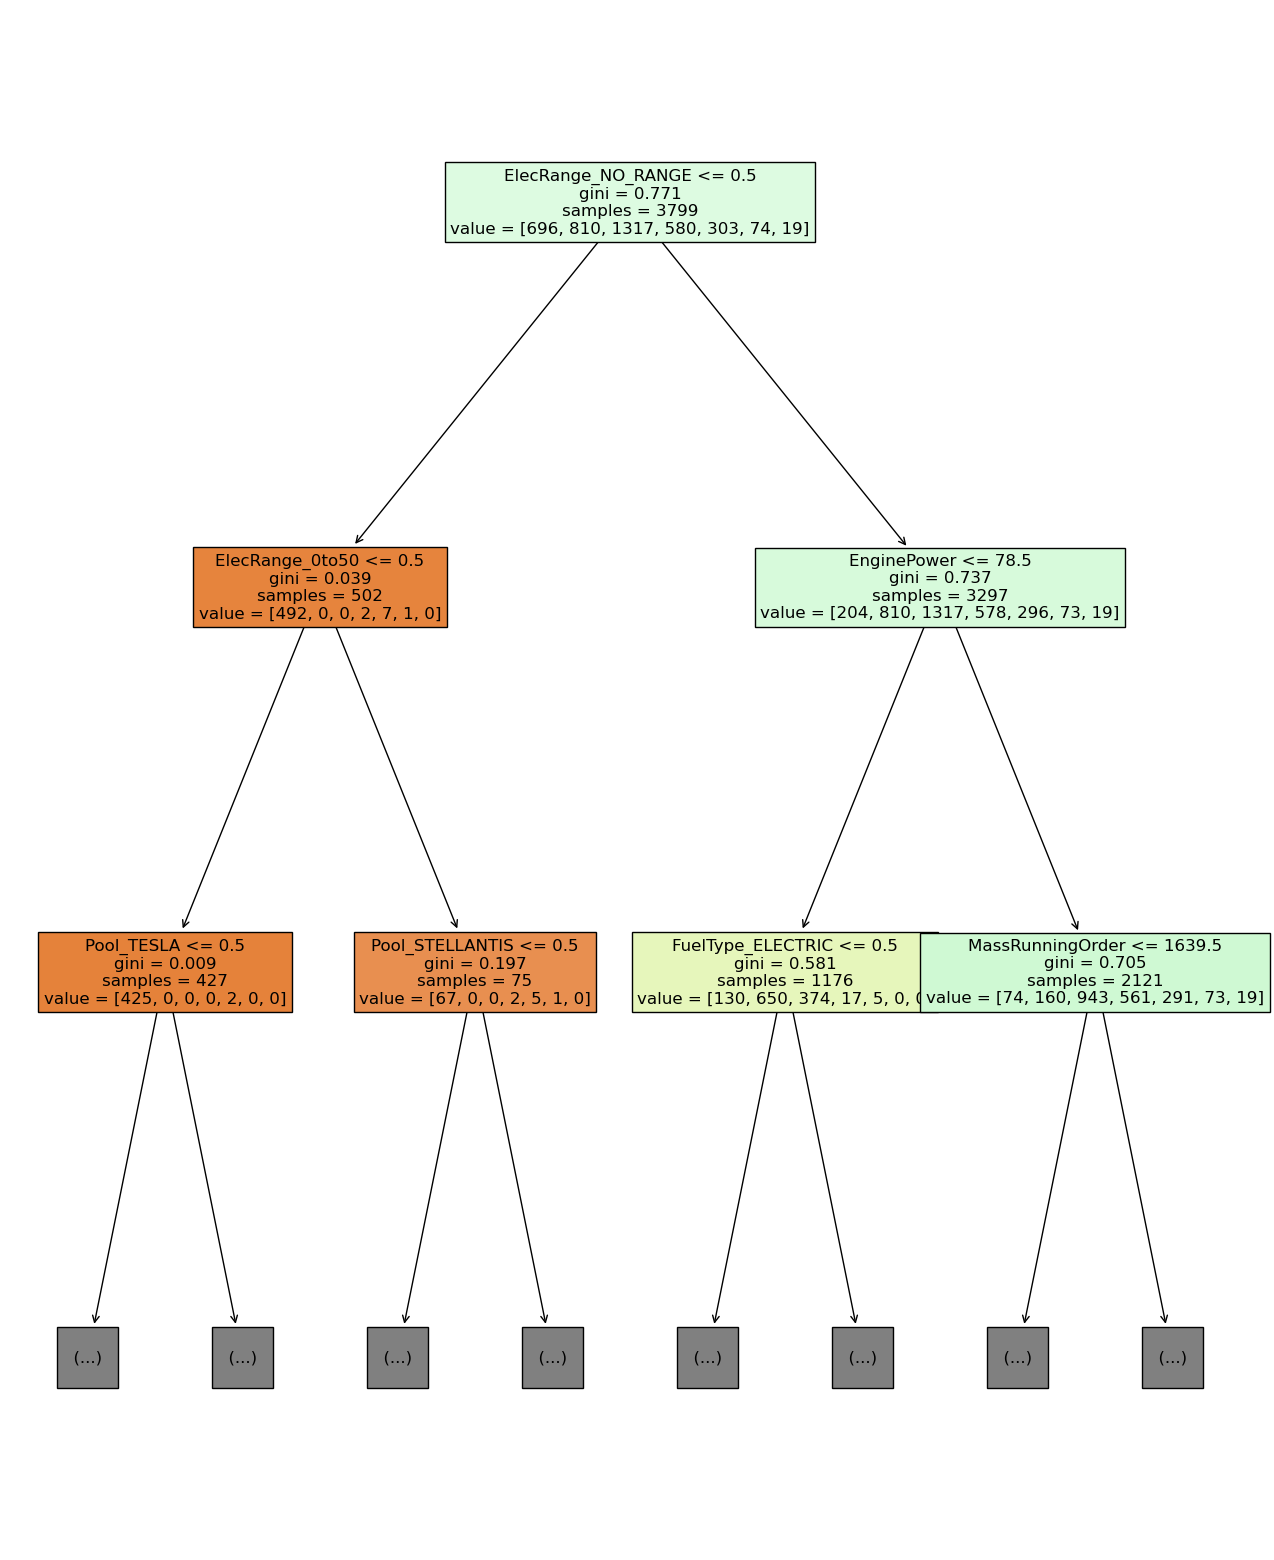

In [6]:
plt.figure(figsize=(16, 20))

plot_tree(dtc, feature_names=X_train.columns.tolist(),
          max_depth=2, filled=True, fontsize=12);

In [7]:
y_pred = dtc.predict_proba(X_test)
co2.viz.plot_roc_curves(y_test, y_pred, title='Decision Tree', interactive=True, save=True, format='png')

## **B. Random Forest**

In [8]:
%%time
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

co2.viz.plot_confusion_matrix(y_test, rfc_pred, palette='Greens', classes=dtc.classes_, title=': Random Forest', save=True, format='png')
co2.styles.display_classification_report(y_test, rfc_pred)

co2.data.save_model(rfc)

,precision,recall,f1-score,support
A,0.982,0.976,0.979,166.000
B,0.876,0.824,0.849,205.000
C,0.857,0.842,0.850,342.000
D,0.783,0.844,0.812,154.000
E,0.768,0.855,0.809,62.000
F,0.667,0.727,0.696,11.000
G,0.889,0.800,0.842,10.000
accuracy,0.861,0.861,0.861,0.861
macro avg,0.832,0.838,0.834,950.000
weighted avg,0.863,0.861,0.862,950.000


Model saved at ../models/RandomForestClassifier_20240114_011612.pkl
CPU times: user 475 ms, sys: 120 ms, total: 595 ms
Wall time: 276 ms


In [9]:
co2.styles.display_feature_importances(rfc, data)

,importance
MassRunningOrder,0.296
EnginePower,0.195
BaseWheel,0.152
FuelType_ELECTRIC,0.059
ElecRange_NO_RANGE,0.058
FuelType_PETROL,0.037
FuelType_DIESEL,0.036
InnovativeTechnology,0.029
FuelType_PETROL/ELECTRIC,0.028
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,0.020


## **2. Réduction de dimensions**

In [10]:
pca = PCA(n_components=None)
data_pca = pca.fit_transform(data)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, target, test_size=.2, random_state=42)

In [11]:
co2.viz.plot_pca_variance(pca, n_features=5, save=True, format='png')

# **3. Modèle d'ensemble: XGBoost**

In [12]:
encoder = LabelEncoder()
target_enc = encoder.fit_transform(target)

X_x, X_valid_x, y_x, y_valid_x = train_test_split(data, target_enc, test_size=.1)
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X_x, y_x, test_size=.2, random_state=42)

In [13]:
%%time

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            n_estimators=4, #400
                            num_class=7, 
                            early_stopping_rounds=20, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            n_jobs=-1,
                            verbosity=2)
xgb_clf.fit(X_train_x, y_train_x, eval_set=[(X_train_x, y_train_x), (X_test_x, y_test_x)])

[0]	validation_0-merror:0.22843	validation_0-mlogloss:1.40151	validation_1-merror:0.27953	validation_1-mlogloss:1.43728
[1]	validation_0-merror:0.16759	validation_0-mlogloss:1.11537	validation_1-merror:0.22339	validation_1-mlogloss:1.17208
[2]	validation_0-merror:0.16467	validation_0-mlogloss:0.94763	validation_1-merror:0.22222	validation_1-mlogloss:1.02002
[3]	validation_0-merror:0.15677	validation_0-mlogloss:0.81651	validation_1-merror:0.21754	validation_1-mlogloss:0.89836
CPU times: user 1.59 s, sys: 36.2 ms, total: 1.63 s
Wall time: 190 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4,
              n_jobs=-1, num_class=7, num_parallel_tree=None, ...)

In [14]:
co2.viz.plot_xgboost(results=xgb_clf.evals_result_, metric='merror', title=' Classifier: Erreur Moyenne')
co2.viz.plot_xgboost(results=xgb_clf.evals_result_, metric='mlogloss', title='Classifier: Moyenne LogLoss')

In [15]:
xgb_pred = xgb_clf.predict(X_test_x)

co2.viz.plot_confusion_matrix(y_test_x, xgb_pred, classes=xgb_clf.classes_, palette='Reds', 
                              title=': XGBoost Classifier', save=True, format='png')
co2.styles.display_classification_report(y_test_x, xgb_pred)

co2.data.save_model(xgb_clf, model_type='xgb')

,precision,recall,f1-score,support
0,0.967,0.961,0.964,154.000
1,0.831,0.747,0.787,178.000
2,0.728,0.837,0.779,301.000
3,0.719,0.613,0.662,142.000
4,0.650,0.672,0.661,58.000
5,0.692,0.529,0.600,17.000
6,0.500,0.200,0.286,5.000
accuracy,0.782,0.782,0.782,0.782
macro avg,0.727,0.651,0.677,855.000
weighted avg,0.784,0.782,0.780,855.000


Model saved at ../models/XGBClassifier_20240114_011612.model


/home/mln/miniconda3/envs/co2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[01:16:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



<Axes: >

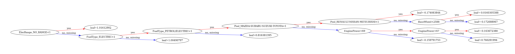

In [16]:
from xgboost import plot_tree
plot_tree(xgb_clf, num_trees=0, rankdir='LR')


In [17]:
co2.viz.plot_feature_importance(xgb_clf, title=': XGBoost Classifier', save=True, format='png')

In [18]:
xgb_valid_pred = xgb_clf.predict(X_valid_x)
co2.viz.plot_confusion_matrix(y_valid_x, xgb_valid_pred, classes=xgb_clf.classes_, palette='Reds',
                              title=': XGBoost Classifier')
co2.styles.display_classification_report(y_valid_x, xgb_valid_pred) 


,precision,recall,f1-score,support
0,0.978,0.967,0.972,90.000
1,0.788,0.698,0.740,96.000
2,0.744,0.851,0.794,174.000
3,0.649,0.587,0.617,63.000
4,0.727,0.632,0.676,38.000
5,0.857,0.667,0.750,9.000
6,1.000,1.000,1.000,5.000
accuracy,0.787,0.787,0.787,0.787
macro avg,0.820,0.772,0.793,475.000
weighted avg,0.788,0.787,0.785,475.000


# **3. Interprétabilité des modèles**

In [19]:
%%time
shap_sample = X_test_x.sample(frac=0.1, random_state=42)
explainer = shap.Explainer(xgb_clf.predict, shap_sample)
# Calculates the SHAP values - It takes some time
shap_values = explainer(shap_sample)
co2.data.save_shap_values(shap_values, shap_sample)

SHAP values saved at ../output/interpretability/Explanation_shap_values_20240114_011616.csv
Explainer information saved at ../output/interpretability/Explanation_explainer_20240114_011616.csv
CPU times: user 25.5 s, sys: 17.5 ms, total: 25.5 s
Wall time: 3.38 s


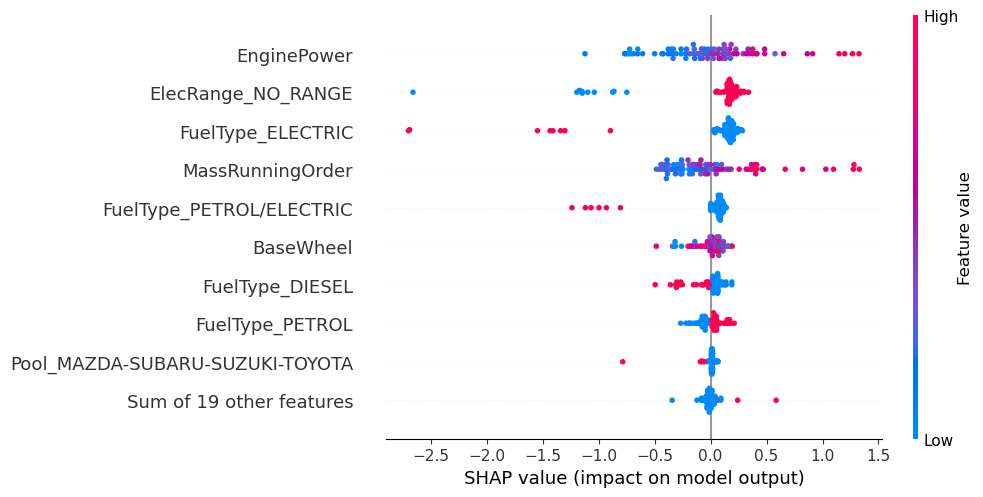

In [20]:
shap.plots.beeswarm(shap_values)

In [21]:
shap.initjs()
shap.plots.force(shap_values[0:300])


In [22]:
#shap.summary_plot(shap_values, X_test_x, plot_type='bar', feature_names=X_test_x.columns)
co2.viz.plot_shap_summary(shap_values, feature_names=X_test_x.columns, title=': XGBoost Classifier', save=True, format='png')

In [23]:
import lime
from lime import lime_tabular

# Create a Lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train_x.to_numpy(), 
                                              feature_names=X_train_x.columns, 
                                              class_names=['0', '1'], 
                                              mode='classification')

# Choose a random instance for which to explain the model's prediction
i = np.random.randint(0, X_test_x.shape[0])

# Get the explanation for the prediction
exp = explainer.explain_instance(X_test_x.iloc[i].to_numpy(), xgb_clf.predict_proba)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)